In [1]:
#This notebook contains a MBS toy calculator.
#The basic design is done in order to reflect
#the impact of the pre-paymanent rate.
#This tool is only meant to work as an academic example.


The MIT License (MIT)

Copyright (c) 2020 Emilio Cabrera

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [2]:
#Libraries
import numpy as np
import pandas as pd
import datetime as dt
import math
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
#data example
dt0 = [1,3,6,12,24,36,60,84,120,180] #Tenor in months
lib0 = [0.16/100,0.24/100,0.33/100,0.26/100,0.53/100,0.97/100,1.41/100,1.75/100,2.04/100,2.23/100] #Interest rate per tenor

In [4]:
node1 = [50]
node2 = [25, 50, 75, 100]

In [5]:
class yield_manager:
    #This class is designed to manage all the related functionalities to yield curves and discounting
    #This class includes interpolation routines
    def __init__(self, yield_curve, tenor, node):
        self.yield_curve = yield_curve
        self.tenor = tenor
        self.node = node
        self.n1 = len(self.yield_curve )
        self.n2 = len(self.tenor)
        self.n3 = len(node)
        
    def check_dim(self):
        return self.n1 == self.n2
    
    def check_tenor_vector(self):
        sum1 = 0
        for i in range(self.n1):
            if i == 0:
                sum1 = (self.tenor[i] > 0)
            elif (self.tenor[i] > 0) and (self.tenor[i] > self.tenor[i - 1]):
                sum1 = (self.tenor[i] > 0) + sum1
            else:
                sum1 = sum1
        
        return sum1 == self.n2
    
    
    
    def interpolator2(self, m1, months, zc_rates):
        n = len(months) - 1
        if m1 <= months[0]:
            return zc_rates[0]
        elif m1 >= months[n]:
            return zc_rates[n]
        else:
            k = 0
            for i in range(n):
                if m1 < months[i]:
                    k = k + 1
            a = (zc_rates[n - k] - zc_rates[n - k - 1])/(months[n - k ] - months[n -k - 1])
            b = zc_rates[n - k - 1] - a * months[n - k -1]
            c = m1*a + b
            return c
        
    def interpolator1(self):
        result = []
        for i in range(self.n3):
            result.append(self.interpolator2(self.node[i], self.tenor, self.yield_curve)) 
            
        return result 

    

In [6]:
my_yield = yield_manager(lib0, dt0, node2)

In [7]:
my_yield.check_dim()

True

In [8]:
my_yield.check_tenor_vector()

True

In [9]:
my_yield.tenor

[1, 3, 6, 12, 24, 36, 60, 84, 120, 180]

In [10]:
my_yield.interpolator1()

[0.005666666666666666,
 0.012266666666666665,
 0.016225000000000003,
 0.01878888888888889]

In [11]:
class tenor_manager:
    def __init__(self, n_payments, days_to_next_payment, coupon_period, day_convention, rates_tenors, yields0):
        self.n_payments0 = n_payments
        self.dtnp = days_to_next_payment
        self.coupon_period = coupon_period
        self.day_convention0 = day_convention
        self.rates_tenors = rates_tenors 
        self.yields0 = yields0
        self.rates_plus_1bp = self.yields0 + np.ones(len(self.rates_tenors)) * 0.0001 #yields vector
        self.rates_minus_1bp = self.yields0 - np.ones(len(self.rates_tenors)) * 0.0001 #yields vector
        self.n3b = len(self.rates_tenors)
        
    def tenor_calculator(self):
        self.tenor_vector0 = np.zeros(self.n_payments0)
        for i in range(self.n_payments0 ):
            if i == 0:
                self.tenor_vector0[i] = self.dtnp/self.day_convention0
            else:
                self.tenor_vector0[i] = self.tenor_vector0[i - 1] + self.dtnp/self.day_convention0
        
        return self.tenor_vector0
    
    def interpolator2b(self, m1, months, zc_rates):
        n = len(months) - 1
        if m1 <= months[0]:
            return zc_rates[0]
        elif m1 >= months[n]:
            return zc_rates[n]
        else:
            k = 0
            for i in range(n):
                if m1 < months[i]:
                    k = k + 1
            a = (zc_rates[n - k] - zc_rates[n - k - 1])/(months[n - k ] - months[n -k - 1])
            b = zc_rates[n - k - 1] - a * months[n - k -1]
            c = m1*a + b
            return c
        
    def interpolator1b(self):
        nx = len(self.tenor_calculator())
        result = []
        for i in range(nx):
            result.append(self.interpolator2b(self.tenor_calculator()[i], self.rates_tenors, self.yields0)) 
            
        return result 
    
    def interpolator1c(self):
        nx = len(self.tenor_calculator())
        result_up = []
        result_down = []
        for i in range(nx):
            
            result_up.append(self.interpolator2b(self.tenor_calculator()[i], self.rates_tenors, self.rates_plus_1bp))
            result_down.append(self.interpolator2b(self.tenor_calculator()[i], self.rates_tenors, self.rates_minus_1bp)) 

        return result_up, result_down 


    
    
    

        

In [113]:
class MBS(tenor_manager):
    def __init__(self, tenor, rates, prepayment, notional, n_payments, days_next_payment,
                 coupon_days, mortg_coupon, bond_coupon, day_convention):
        self.tenors = tenor #Tenor vector of the yield curve
        self.rates = rates #yields vector
        
        self.prepayment = prepayment #prepayment rate
        self.prepayment_adj = 1 - (1 - self.prepayment)**(1/12) #Adjustment prepayment per month
        self.notional = notional #face value
        #self.frequency = frequency
        #self.date0 = date0
        #self.date1 = date1
        self.mortg_coupon = mortg_coupon #average mortgage coupon payment
        self.bond_coupon = bond_coupon #pass-through coupon
        self.n_payments = n_payments #number of payments  are equal for the mortgage and for the pass-through
        self.next_payment = days_next_payment # days for the next coupon
        self.coupon_days = coupon_days #days for the period of each coupon
        self.day_convention = day_convention #360 or 365 or 28 for months
        self.A = 1 / (1 + self.mortg_coupon * self.day_convention/360)
        self.C = self.notional / self.A * (1 - self.A)/(1 - self.A**self.n_payments)
        tenor_manager.__init__(self, n_payments = self.n_payments,
                               days_to_next_payment = self.next_payment, 
                               coupon_period = self.coupon_days, 
                               day_convention = self.day_convention,
                               rates_tenors = self.tenors, yields0 = self.rates)
        
        
    def return_tenors(self):
        return self.tenor_calculator()
    
    def return_interpolated_yields(self):
        return self.interpolator1b()
    
    def return_stressed_interpolated_yields(self):
        return self.interpolator1c()
    
    def return_disc_factors(self):
        self.df_vector = np.zeros(self.n_payments)
        for i in range(self.n_payments):
            self.df_vector[i] = 1/(1 + 
                                   self.return_interpolated_yields()[i]*self.return_tenors()[i]/self.day_convention)
            
        return self.df_vector
    
    def return_disc_factors2(self):
        self.df_vector_up = np.zeros(self.n_payments)
        self.df_vector_down = np.zeros(self.n_payments)
        self.yields_1bps_plus = np.array(self.return_stressed_interpolated_yields())[1,:]
        self.yields_1bps_minus = np.array(self.return_stressed_interpolated_yields())[0,:]
        for i in range(self.n_payments):
            self.df_vector_up[i] = 1/(1 + 
                                   self.yields_1bps_plus[i]*self.return_tenors()[i]/self.day_convention)
            self.df_vector_down[i] = 1/(1 + 
                                   self.yields_1bps_minus[i]*self.return_tenors()[i]/self.day_convention)
        
        return self.df_vector_down, self.df_vector_up
    
    
    
    def return_mortg_cf_pv(self):
        self.pv_cf_mtg_vector = np.zeros(self.n_payments)
        self.df_vector = self.return_disc_factors()
        for i in range(self.n_payments):
            self.pv_cf_mtg_vector[i] = self.notional * self.mortg_coupon * self.df_vector[i] * self.day_convention/360
            
        return self.pv_cf_mtg_vector
    
    def mbs_pricing(self ):
        self.tenor1 = self.return_tenors()
        self.cf_investors = np.zeros(self.n_payments)
        self.mort_rate = np.zeros(self.n_payments)
        self.diff1 = np.zeros(self.n_payments)
        self.pp_investors = np.zeros(self.n_payments)
        self.int_pp = np.zeros(self.n_payments)
        self.cf_to_pp = np.zeros(self.n_payments)
        self.balance = np.zeros(self.n_payments)
        self.df = self.return_disc_factors()#np.zeros(self.n_payments)
        self.pv = np.zeros(self.n_payments)
        #adj_pp = self.prepayment_adj
        
            
        for i in range(self.n_payments):
            if i == 0:
                self.tenor1[i] = i + 1
                self.cf_investors[i] = self.C
                self.mort_rate[i] = self.notional * self.mortg_coupon / 12
                self.diff1[i] = self.cf_investors[i] - self.mort_rate[i]
                self.pp_investors[i] = self.notional * self.prepayment_adj
                self.int_pp[i] = self.notional * self.bond_coupon / 12
                self.cf_to_pp[i] = self.int_pp[i] + self.pp_investors[i] + self.diff1[i]
                self.balance[i] = max(self.notional - self.diff1[i] -  self.pp_investors[i], 0)
                #self.df[i] = 1/(1 + self.tenor1[i]*interpolator(tenor1[i],dt0,libor)/12)
                self.pv[i] = self.cf_to_pp[i] * self.df[i]
            else:
                self.tenor1[i] = i + 1
                self.cf_investors[i] = self.cf_investors[i-1]*(1 - self.prepayment_adj)
                self.mort_rate[i] = self.balance[i-1] * self.mortg_coupon / 12 #Change Mortgage to updated capital
                self.diff1[i] = self.cf_investors[i] - self.mort_rate[i]
                self.pp_investors[i] = self.balance[i-1] * self.prepayment_adj #Change L for updated Capital
                self.int_pp[i] = self.balance[i-1] * self.bond_coupon / 12 #Change L for updated Capital
                self.cf_to_pp[i] = self.int_pp[i] + self.pp_investors[i] + self.diff1[i]
                self.balance[i] = max(self.balance[i-1] - self.diff1[i] -  self.pp_investors[i],0)
                #df[i] = 1/(1 + tenor1[i]*interpolator(tenor1[i],dt0,libor)/12)#Function to interpolate
                self.pv[i] = self.cf_to_pp[i] * self.df[i]
        return(sum(self.pv))
    
    def mbs_pricing2(self, pp_rate):
        self.tenor1 = self.return_tenors()
        self.cf_investors = np.zeros(self.n_payments)
        self.mort_rate = np.zeros(self.n_payments)
        self.diff1 = np.zeros(self.n_payments)
        self.pp_investors = np.zeros(self.n_payments)
        self.int_pp = np.zeros(self.n_payments)
        self.cf_to_pp = np.zeros(self.n_payments)
        self.balance = np.zeros(self.n_payments)
        self.df = self.return_disc_factors()#np.zeros(self.n_payments)
        self.df_up = np.array(self.return_disc_factors2())[1,:]#np.array(self.return_disc_factors2())[1,:]
        self.df_down = np.array(self.return_disc_factors2())[0,:]#np.array(self.return_disc_factors2())[0,:]
        self.pv = np.zeros(self.n_payments)
        self.pv_up = np.zeros(self.n_payments)
        self.pv_down = np.zeros(self.n_payments)
        #adj_pp = self.prepayment_adj
        
            
        for i in range(self.n_payments):
            if i == 0:
                self.tenor1[i] = i + 1
                self.cf_investors[i] = self.C
                self.mort_rate[i] = self.notional * self.mortg_coupon / 12
                self.diff1[i] = self.cf_investors[i] - self.mort_rate[i]
                self.pp_investors[i] = self.notional * pp_rate#self.prepayment_adj
                self.int_pp[i] = self.notional * self.bond_coupon / 12
                self.cf_to_pp[i] = self.int_pp[i] + self.pp_investors[i] + self.diff1[i]
                self.balance[i] = max(self.notional - self.diff1[i] -  self.pp_investors[i], 0)
                #self.df[i] = 1/(1 + self.tenor1[i]*interpolator(tenor1[i],dt0,libor)/12)
                self.pv[i] = self.cf_to_pp[i] * self.df[i]
                self.pv_up[i] = self.cf_to_pp[i] * self.df_up[i]
                self.pv_down[i] = self.cf_to_pp[i] * self.df_down[i]
            else:
                self.tenor1[i] = i + 1
                self.cf_investors[i] = self.cf_investors[i-1]*(1 - self.prepayment_adj)
                self.mort_rate[i] = self.balance[i-1] * self.mortg_coupon / 12 #Change Mortgage to updated capital
                self.diff1[i] = self.cf_investors[i] - self.mort_rate[i]
                self.pp_investors[i] = self.balance[i-1] * pp_rate#self.prepayment_adj #Change L for updated Capital
                self.int_pp[i] = self.balance[i-1] * self.bond_coupon / 12 #Change L for updated Capital
                self.cf_to_pp[i] = self.int_pp[i] + self.pp_investors[i] + self.diff1[i]
                self.balance[i] = max(self.balance[i-1] - self.diff1[i] -  self.pp_investors[i],0)
                #df[i] = 1/(1 + tenor1[i]*interpolator(tenor1[i],dt0,libor)/12)#Function to interpolate
                self.pv[i] = self.cf_to_pp[i] * self.df[i]
                self.pv_up[i] = self.cf_to_pp[i] * self.df_up[i]
                self.pv_down[i] = self.cf_to_pp[i] * self.df_down[i]
        return(sum(self.pv), sum(self.pv_up), sum(self.pv_down))
    
    
        
       
    
    def prepayment_sensitivity(self): #Under review!
        self.max1 = self.prepayment_adj * 1.5
        self.min1 = self.prepayment_adj * 1/1.5
        self.pp_scenarios1 = (np.array(range(100)) + 1)/100 * (self.max1 - self.min1) + self.min1
        self.pv_scenarios = np.array(list(map(self.mbs_pricing2, self.pp_scenarios1)))
        m1 = pd.DataFrame([self.pp_scenarios1, self.pv_scenarios[:,0], self.pv_scenarios[:,1], self.pv_scenarios[:,2]])
        m1 = m1.T
        m1.columns = ["Prepayment", "PV", "PV_down_1bps", "PV_up_1bps"]
        plt.plot( 'Prepayment', 'PV', data=m1, color='skyblue', )
        plt.plot( 'Prepayment', 'PV_down_1bps', data=m1,  color='green' )
        plt.plot( 'Prepayment', 'PV_up_1bps', data=m1,  color='olive')
        plt.legend()
        plt.show()

        
        #return m1
        #m1.columns = ["Prepayment", "PV", "PV_up_1bps", "PV_down_1bps"]
        #sns.lineplot(x= "Prepayment", y ="PV", data = m1)
        #plt.show()
        
   
        

In [114]:
my_mbs = MBS(dt0, lib0, 0.05, 100, 100, 28, 28, 0.08, 0.05, 28)

In [115]:
my_mbs.return_tenors()

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

In [116]:
my_mbs.return_interpolated_yields()

[0.0016,
 0.002,
 0.0024,
 0.0027,
 0.003,
 0.0033,
 0.003183333333333333,
 0.0030666666666666668,
 0.00295,
 0.0028333333333333335,
 0.0027166666666666667,
 0.0026,
 0.002825,
 0.00305,
 0.003275,
 0.0035,
 0.003725,
 0.00395,
 0.004175,
 0.0044,
 0.004625,
 0.00485,
 0.0050750000000000005,
 0.0053,
 0.005666666666666666,
 0.006033333333333332,
 0.0064,
 0.0067666666666666665,
 0.007133333333333333,
 0.007499999999999999,
 0.007866666666666668,
 0.008233333333333332,
 0.0086,
 0.008966666666666668,
 0.009333333333333332,
 0.0097,
 0.009883333333333334,
 0.010066666666666668,
 0.01025,
 0.010433333333333333,
 0.010616666666666667,
 0.0108,
 0.010983333333333335,
 0.011166666666666668,
 0.011349999999999999,
 0.011533333333333333,
 0.011716666666666667,
 0.0119,
 0.012083333333333335,
 0.012266666666666665,
 0.01245,
 0.012633333333333333,
 0.012816666666666667,
 0.013000000000000001,
 0.013183333333333332,
 0.013366666666666666,
 0.01355,
 0.013733333333333334,
 0.013916666666666667,
 

In [117]:
np.array(my_mbs.return_stressed_interpolated_yields())

array([[0.0017    , 0.0021    , 0.0025    , 0.0028    , 0.0031    ,
        0.0034    , 0.00328333, 0.00316667, 0.00305   , 0.00293333,
        0.00281667, 0.0027    , 0.002925  , 0.00315   , 0.003375  ,
        0.0036    , 0.003825  , 0.00405   , 0.004275  , 0.0045    ,
        0.004725  , 0.00495   , 0.005175  , 0.0054    , 0.00576667,
        0.00613333, 0.0065    , 0.00686667, 0.00723333, 0.0076    ,
        0.00796667, 0.00833333, 0.0087    , 0.00906667, 0.00943333,
        0.0098    , 0.00998333, 0.01016667, 0.01035   , 0.01053333,
        0.01071667, 0.0109    , 0.01108333, 0.01126667, 0.01145   ,
        0.01163333, 0.01181667, 0.012     , 0.01218333, 0.01236667,
        0.01255   , 0.01273333, 0.01291667, 0.0131    , 0.01328333,
        0.01346667, 0.01365   , 0.01383333, 0.01401667, 0.0142    ,
        0.01434167, 0.01448333, 0.014625  , 0.01476667, 0.01490833,
        0.01505   , 0.01519167, 0.01533333, 0.015475  , 0.01561667,
        0.01575833, 0.0159    , 0.01604167, 0.01

In [118]:
my_mbs.return_disc_factors()

array([0.99994286, 0.99985716, 0.99974292, 0.99961443, 0.99946457,
       0.99929336, 0.9992048 , 0.99912458, 0.99905268, 0.99898912,
       0.99893388, 0.99888695, 0.99869011, 0.99847732, 0.99824861,
       0.99800399, 0.9977435 , 0.99746715, 0.99717497, 0.99686699,
       0.99654324, 0.99620375, 0.99584856, 0.99547769, 0.99496595,
       0.99442883, 0.99386642, 0.99327881, 0.99266609, 0.99202834,
       0.99136568, 0.99067819, 0.98996599, 0.98922918, 0.98846787,
       0.98768219, 0.98710825, 0.98652223, 0.98592417, 0.98531413,
       0.98469214, 0.98405826, 0.98341252, 0.98275499, 0.9820857 ,
       0.98140472, 0.98071208, 0.98000784, 0.97929205, 0.97856477,
       0.97782605, 0.97707594, 0.97631449, 0.97554177, 0.97475783,
       0.97396273, 0.97315652, 0.97233926, 0.97151102, 0.97067184,
       0.96990719, 0.96913423, 0.96835301, 0.96756358, 0.96676598,
       0.96596025, 0.96514644, 0.96432458, 0.96349473, 0.96265693,
       0.96181123, 0.96095766, 0.96009628, 0.95922714, 0.95835

In [119]:
my_mbs.return_disc_factors2()

(array([0.99993929, 0.99985002, 0.99973221, 0.99960016, 0.99944673,
        0.99927196, 0.99917984, 0.99909606, 0.9990206 , 0.99895348,
        0.99889468, 0.99884419, 0.99864381, 0.99842748, 0.99819523,
        0.99794708, 0.99768306, 0.99740319, 0.9971075 , 0.99679601,
        0.99646876, 0.99612578, 0.9957671 , 0.99539275, 0.99487756,
        0.99433701, 0.99377118, 0.99318016, 0.99256404, 0.99192291,
        0.99125688, 0.99056604, 0.9898505 , 0.98911037, 0.98834576,
        0.98755678, 0.98697951, 0.98639016, 0.9857888 , 0.98517546,
        0.98455018, 0.98391302, 0.98326403, 0.98260324, 0.98193072,
        0.98124651, 0.98055066, 0.97984323, 0.97912425, 0.9783938 ,
        0.97765192, 0.97689867, 0.9761341 , 0.97535827, 0.97457123,
        0.97377305, 0.97296377, 0.97214346, 0.97131218, 0.97046998,
        0.96970229, 0.9689263 , 0.96814207, 0.96734965, 0.96654906,
        0.96574036, 0.96492359, 0.9640988 , 0.96326602, 0.96242531,
        0.96157671, 0.96072027, 0.95985602, 0.95

In [120]:
my_mbs.return_mortg_cf_pv()

array([0.62218667, 0.62213335, 0.62206226, 0.62198231, 0.62188907,
       0.62178253, 0.62172743, 0.62167751, 0.62163278, 0.62159323,
       0.62155886, 0.62152966, 0.62140718, 0.62127478, 0.62113247,
       0.62098026, 0.62081818, 0.62064622, 0.62046442, 0.62027279,
       0.62007135, 0.61986011, 0.6196391 , 0.61940834, 0.61908992,
       0.61875572, 0.61840578, 0.61804015, 0.6176589 , 0.61726208,
       0.61684975, 0.61642198, 0.61597884, 0.61552038, 0.61504668,
       0.61455781, 0.61420069, 0.61383605, 0.61346393, 0.61308435,
       0.61269733, 0.61230291, 0.61190113, 0.61149199, 0.61107555,
       0.61065182, 0.61022085, 0.60978266, 0.60933728, 0.60888475,
       0.6084251 , 0.60795836, 0.60748457, 0.60700377, 0.60651599,
       0.60602125, 0.60551961, 0.6050111 , 0.60449574, 0.60397359,
       0.6034978 , 0.60301685, 0.60253076, 0.60203956, 0.60154328,
       0.60104193, 0.60053556, 0.60002418, 0.59950783, 0.59898654,
       0.59846032, 0.59792921, 0.59739324, 0.59685244, 0.59630

In [121]:
my_mbs.mbs_pricing()

115.93814742464451

In [122]:
my_mbs.mbs_pricing2(0.1)

(182.56376063755698, 182.58264997307467, 182.54487890630253)

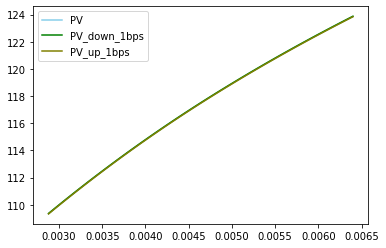

In [123]:
my_mbs.prepayment_sensitivity()

In [ ]:
my_mbs.mbs_pricing2(0.10)

In [ ]:
np.ones(10) * 0.00001

In [ ]:
np.array(my_mbs.return_disc_factors2())[0,:]